#LAB 8 : Classification

  1. Support Vector Machines 
  2. K-Nearest Neighbors
  3. Classification on MNIST Digit 

In [1]:
#importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
import idx2numpy
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#Support Vector Machines (SVM)



1. Try to maximize the margin of separation between data.
2. Instead of learning wx+b=0  separating hyperplane directly (like logistic regression), SVM try to learn wx+b=0, such that, the margin between two hyperplanes wx+b=1 and wx+b=-1 (also known as support vectors) is maximum. 
3. Margin between wx+b=1 and wx+b=-1 hyperplane is $\frac{2}{||w||}$
4. we have a constraint optimization problem of maximizing $\frac{2}{||w||}$, with constraints wx+b>=1 (for +ve class) and wx+b<=-1 (for -ve class).
5. As $y_{i}=1$ for +ve class and $y_{i}=-1$ for -ve class, the constraint can be re-written as:
$$y(wx+b)>=1$$

6. Final optimization is (i.e to find w and b):
$$\min_{||w||}\frac{1}{2}||w||,$$
$$y(wx+b) \geq 1,~\forall ~data $$



Acknowledgement:

https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

## Data generation:
1. Generate 2D gaussian data with fixed mean and variance for 2 class.(var=Identity, class1: mean[-4,-4], class2: mean[1,1], No. of data 25 from each class)
2. create the label matrix
3. Plot the generated data

(50, 2)
(50,)


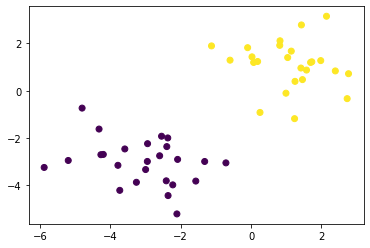

In [2]:
#Data generation

No_sample=50
mean1=np.array([-3,-3])
var1=np.array([[1,0],[0,1]])
mean2=np.array([1,1])
var2=var1
data1=np.random.multivariate_normal(mean1,var1,int(No_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_sample/2))
X=np.concatenate((data1,data2))
print(X.shape)
y=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))
print(y.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',c=y)

Create a data dictionary, which contains both label and data points.

In [3]:
#create lists for -1 , 1 labelled data and then convert them into a dictionary

postiveX=[]
negativeX=[]

for i,v in enumerate(y):
    if v==-1:
        negativeX.append(X[i])
    else:
        postiveX.append(X[i])

#our data dictionary
data_dict = {-1:np.array(negativeX), 1:np.array(postiveX)} 

## SVM training
1. create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and  for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
2. we will start with a higher step and find optimal w and b, then we will reduce the step and again re-evaluate the optimal one.

3. In each step, we will take transform of w, [1,1], [-1,1],[1,-1] and [-1,-1] to search arround the w. 

4. In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition $y(wx+b) \geq 1$. 

5. Obtain the optimal hyperplane having minimum ||w||.

6. Start with the optimal w and repeat the same (step 3,4 and 5) for a reduced step size.


In [4]:
# it is just a searching algorithem, not a complicated optimization algorithem, (just for understanding of concepts through visualization)

def SVM_Training(dict_data):
    
    #intialize the length vector and the possible transforms
    length_Wdict = {}
    w_transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]

    max_feature_value = np.max([np.max(np.abs(dict_data[1])),np.max(np.abs(dict_data[-1]))])
    
    #create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
    steps = [max_feature_value * 0.1, max_feature_value * 0.01, max_feature_value * 0.001]

    b_step_size = 2
    b_multiple = 5
    w_optimal = max_feature_value*0.5

    for step in steps:
        
        w = np.array([w_optimal,w_optimal])     
        srch_comp = False
        while not srch_comp:
            #we want to maximize the b values so check for every b value
            for b in np.arange(-1*(max_feature_value*b_step_size), max_feature_value*b_step_size, step*b_multiple):
                for transformation in w_transforms:  # transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
                    w_t = w*transformation
                    
                    correctly_classified = True
                    
                    #In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition  𝑦(𝑤𝑥+𝑏)≥1 .
                    for yi in dict_data:
                        for xi in dict_data[yi]:
                            if yi*(np.dot(w_t,xi)+b) < 1:  # we want  yi*(np.dot(w_t,xi)+b) >= 1 for correct classification
                                correctly_classified = False
                                
                    if correctly_classified:
                        length_Wdict[np.linalg.norm(w_t)] = [w_t,b] #store w, b for minimum magnitude
            
            if w[0] < 0:
                srch_comp = True
            else:
                w = w - step

        norms = sorted([n for n in length_Wdict]) # sort the heated norms
        
        minimum_wlength = length_Wdict[norms[0]]
        w = minimum_wlength[0]
        b = minimum_wlength[1]
        
        w_optimal = w[0] # w1 and w2 are same
    
    return w,b

**Training**

In [5]:
# All the required variables 
w=[] # Weights 2 dimensional vector
b=[] # Bias
w,b=SVM_Training(data_dict)
print(w)
print(b)

[0.65262921 0.65262921]
1.4404878944626276


## Visualization of the SVM separating hyperplanes (after training)

In [6]:
def visualize(data_dict):
       
        plt.scatter(X[:,0],X[:,1],marker='o',c=y)

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        
        hyp_x_min = np.min([np.min(data_dict[1]),np.min(data_dict[-1])])
        hyp_x_max = np.max([np.max(data_dict[1]),np.max(data_dict[-1])])

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane_value(hyp_x_min, w, b, 1)
        psv2 = hyperplane_value(hyp_x_max, w, b, 1)
        plt.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
        nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
        plt.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # best margin
        db1 = hyperplane_value(hyp_x_min, w, b, 0)
        db2 = hyperplane_value(hyp_x_max, w, b, 0)
        plt.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        

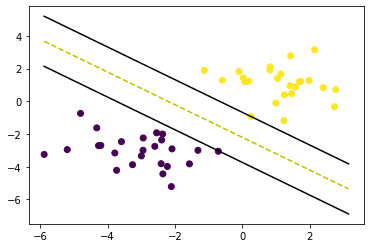

In [7]:
fig = plt.figure()
visualize(data_dict)

**Testing**

In [8]:
def predict(data,w,b):
    y_pred=np.sign(np.dot(data,w)+b)
    return y_pred

test accuracy= 100.0


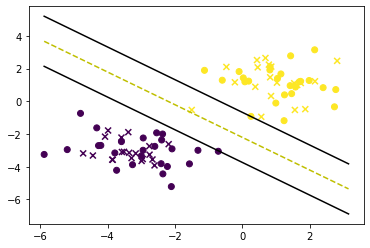

In [9]:
No_test_sample=40

data1=np.random.multivariate_normal(mean1,var1,int(No_test_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_test_sample/2))
test_data=np.concatenate((data1,data2))
y_gr=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))

# evaluate with the trained model

y_pred = predict(test_data,w,b)
accuracy = (1-(np.abs(0.5*np.sum(y_pred-y_gr))/y_pred.shape[0]))*100
print('test accuracy=',accuracy)

#  Visualization
plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_gr)


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the SVM algorithm**

In [10]:
#using linear support vector

#model generation
svm = LinearSVC()

#fitting model
svm.fit(X,y)

#model paramters
tr_Acc = svm.score(X,y)
print('Train accuracy SVM =',tr_Acc*100)

Train accuracy SVM = 100.0


In [11]:
# svm testing

y_pred = svm.predict(test_data)

#confusion matrix and test accuracy printing
svm_Acc = svm.score(test_data,y_gr)
print('Test accuracy SVM=',svm_Acc*100)
print('Confusion matrix=\n',conf_mat(y_gr,y_pred))

Test accuracy SVM= 97.5
Confusion matrix=
 [[20  0]
 [ 1 19]]


#K-Nearest Neighbours (KNN)

Text(0.5, 1.0, 'Data visualization')

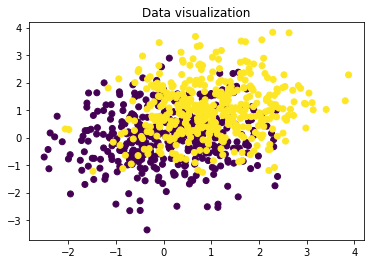

In [12]:
import numpy as np
import matplotlib.pyplot as plt

mean1=np.array([0,0])
mean2=np.array([1,1])
var=np.array([[1,0.1],[0.1,1]])
np.random.seed(0)
data1=np.random.multivariate_normal(mean1,var,500)
data2=np.random.multivariate_normal(mean2,var,500)
data_train=np.concatenate((data1[:-100,],data2[:-100]))
label=np.concatenate((np.zeros(data1.shape[0]-100),np.ones(data2.shape[0]-100)))

plt.figure()
plt.scatter(data_train[:,0],data_train[:,1],c=label)
plt.title('Data visualization')

In [13]:
def euclidean_distance(row1, row2):
    return np.linalg.norm(row1-row2)

In [14]:
def get_neighbors(train,label_train, test_row, num_neighbors):
    
    distances = list()
    
    for i in range(train.shape[0]):
        train_row=train[i,:]
        label_row=label_train[i]
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist,label_row))
        
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    
    for i in range(num_neighbors):
        neighbors.append(distances[i])
    
    return neighbors


In [15]:
def predict_classification(neigbors):
    pred=list()
    
    for i in range(len(neigbors)):
        pred.append(neigbors[i][2])
        
    prediction = max(set(pred), key=pred.count)
    
    return prediction

In [16]:
# test data generation

data_test=np.concatenate((data1[-100:],data2[-100:]))
label_test=np.concatenate((np.zeros(100),np.ones(100)))

In [17]:
#initialize K as number of nearest neighbours
K=2

pred_label=np.zeros(data_test.shape[0])

for i in range(data_test.shape[0]):
    neig=get_neighbors(data_train,label, data_test[i,:], K)
    pred_label[i]=predict_classification(neig)

#get paramters
accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


In [30]:
#initialize K as number of nearest neighbours
K=3

pred_label=np.zeros(data_test.shape[0])

for i in range(data_test.shape[0]):
    neig=get_neighbors(data_train,label, data_test[i,:], K)
    pred_label[i]=predict_classification(neig)

#get paramters
accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 71.5 %


In [31]:
#initialize K as number of nearest neighbours
K=4

pred_label=np.zeros(data_test.shape[0])

for i in range(data_test.shape[0]):
    neig=get_neighbors(data_train,label, data_test[i,:], K)
    pred_label[i]=predict_classification(neig)

#get paramters
accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 70.0 %


In [36]:
#initialize K as number of nearest neighbours
K=15

pred_label=np.zeros(data_test.shape[0])

for i in range(data_test.shape[0]):
    neig=get_neighbors(data_train,label, data_test[i,:], K)
    pred_label[i]=predict_classification(neig)

#get paramters
accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 74.0 %


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the K-Nearest Neighbour algorithm**

In [18]:
#KNN model sklearn

model = KNeighborsClassifier(n_neighbors=2)
model.fit(data_train,label)
pred_label = model.predict(data_test)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


#Classification on MNIST Digit Data

1. Read MNIST data and perform train-test split
2. Select any 2 Classes and perform classification task using SVM, KNN and Logistic Regression algorithms with the help of Sci-Kit Learn tool
3. Report the train and test accuracy and also display the results using confusion matrix
4. Repeat steps 2 and 3 for all 10 Classes and tabulate the results

**Note : If you are interested, also try classifying MNIST digit data using the code you have written for SVM, KNN and Logistic Regression** 

  

In [19]:
#file importing

file1='t10k-images-idx3-ubyte'
file2='t10k-labels-idx1-ubyte'

# input image dimensions
img_rows, img_cols = 28, 28

#choose two class you want to evaluate
cl1, cl2 = 2, 9 

x_train= idx2numpy.convert_from_file(file1)
y_train= idx2numpy.convert_from_file(file2)

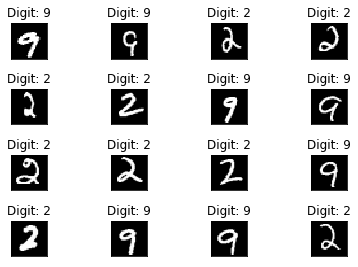

In [20]:
i, = np.where(y_train == cl1)
j, = np.where(y_train == cl2)

cl1_train=x_train[i,:,:]
cl1_label=y_train[i]

cl2_train=x_train[j,:,:]
cl2_label=y_train[j]

train_com = np.concatenate((cl1_train,cl2_train),axis=0)
train_lab = np.concatenate((cl1_label,cl2_label),axis=0)

[train_sff,train_labs]=shuffle(train_com,train_lab)


fig = plt.figure()

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(train_sff[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(train_labs[i]))
    plt.xticks([])
    plt.yticks([])
fig

np.place(train_labs, train_labs==cl1, [0])
np.place(train_labs, train_labs==cl2, [1])

train_sff = train_sff.astype('float32')

train_sff /= 255

#flattern the input data
ftrain_sff=train_sff.reshape(train_labs.shape[0],img_rows*img_cols)

In [21]:
# testing data
file1='t10k-images-idx3-ubyte'
file2='t10k-labels-idx1-ubyte'

x_test= idx2numpy.convert_from_file(file1)
y_test= idx2numpy.convert_from_file(file2)

In [22]:
i, = np.where(y_test == cl1)      
j, = np.where(y_test == cl2)
cl1_test=x_test[i,:,:]
cl1_label=y_test[i]


cl2_test=x_test[j,:,:]
cl2_label=y_test[j]

test_com = np.concatenate((cl1_test,cl2_test),axis=0)
test_lab=np.concatenate((cl1_label,cl2_label),axis=0)

np.place(test_lab, test_lab==cl1, [0])
np.place(test_lab, test_lab==cl2, [1])

#flattern the input data
test_com = test_com.astype('float32')

test_com /= 255

ftest_com=test_com.reshape(test_lab.shape[0],img_rows*img_cols)

In [23]:
#LR Training
Lreg = LogisticRegression(solver='liblinear')
Lreg.fit(ftrain_sff[0:2000,:],train_labs[0:2000])

LR_tr_Acc = Lreg.score(ftrain_sff[0:2000,:],train_labs[0:2000])

print('Train accuracy Logistic regression=',LR_tr_Acc*100)

Train accuracy Logistic regression= 99.85000000000001


In [24]:
y_pred = Lreg.predict(ftest_com)
Lreg_Acc = Lreg.score(ftest_com,test_lab)
print('Test accuracy Logistic regression=',Lreg_Acc*100)
print('Confusion matrix=\n',conf_mat(test_lab,y_pred))

Test accuracy Logistic regression= 99.80401763841255
Confusion matrix=
 [[1029    3]
 [   1 1008]]


In [25]:
# svm training
svm = LinearSVC()
svm.fit(ftrain_sff[0:2000,:],train_labs[0:2000])

tr_Acc=svm.score(ftrain_sff[0:2000,:],train_labs[0:2000])
print('Train accuracy SVM=',tr_Acc*100)

Train accuracy SVM= 100.0


In [26]:
# svm testing
y_pred = svm.predict(ftest_com)
svm_Acc = svm.score(ftest_com,test_lab)
print('Test accuracy SVM=',svm_Acc*100)
print('Confusion matrix=\n',conf_mat(test_lab,y_pred))

Test accuracy SVM= 99.95100440960314
Confusion matrix=
 [[1031    1]
 [   0 1009]]


In [37]:
#knn testing

#KNN model sklearn

model = KNeighborsClassifier(n_neighbors=2)
model.fit(ftrain_sff[0:2000,:],train_labs[0:2000])
pred_label = model.predict(ftest_com)
acc_knn = model.score(ftest_com,test_lab)

print('Test accuracy KNN',acc_knn*100)
print('Confusion matrix=\n',conf_mat(test_lab,pred_label))

Test accuracy KNN 99.8530132288094
Confusion matrix=
 [[1032    0]
 [   3 1006]]
